In [3]:
import numpy as np

def y_sum(img,y_origin,top, diff_staff):
    
    
    temp = (y_origin+np.argmax(np.sum(img,axis=1)))
    #print('sum', np.sum(img,axis=1))
    #print('amax', np.amax(np.sum(img,axis=1)), 'arg', np.argmax(np.sum(img,axis=1)))
    a = np.argmin(np.abs(top - temp))
    if(a%2 == 0):
        flag = 1 #Treble
    else:
        flag = 0 #Bass
    diff = (temp - top[a])/diff_staff[a]
    
    diff = (np.round(diff))
    if(flag == 1):
        if(diff == 0):
            return ('F4')
        elif (diff == 1):
            return ('E4')
        elif(diff == 2):
            return ('D4')
        elif(diff == 3):
            return('C4')
        elif(diff == 4):
            return('B4')
        elif(diff == 5):
            return('A4')
        elif(diff == 6):
            return('G3')
        elif(diff == 7):
            return('F3')
        elif(diff == 8):
            return('E3')
        elif(diff == 9):
            return('D3')
        elif(diff == 10):
            return('C3')
    
    else:
        if(diff == 0):
            return ('A3')
        elif (diff == 1):
            return ('G2')
        elif(diff == 2):
            return ('F2')
        elif(diff == 3):
            return('E2')
        elif(diff == 4):
            return('D2')
        elif(diff == 5):
            return('C2')
        elif(diff == 6):
            return('B2')
        elif(diff == 7):
            return('A2')
        elif(diff == 8):
            return('G1')
        elif(diff == 9):
            return('F1')
        elif(diff == 10):
            return('E1')
     
    #print('diff',diff)
    #return(diff)
    

ret2 160.0


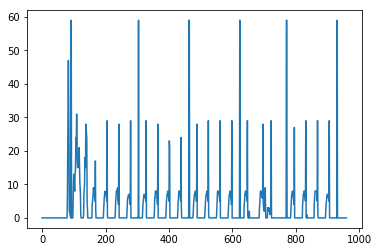

(array([ 83,  92, 304, 463, 464, 623, 770, 771, 930], dtype=int64),)
[[  9 212 159   1 159 147   1 159]]
[  1   9 212 159   1 159 147   1 159]
measures [ 92 304 463 623 770 930]


In [6]:
import cv2
import numpy as np
import csv
import matplotlib.pyplot as plt
import os


font = cv2.FONT_HERSHEY_SIMPLEX

img = cv2.imread('ode_to_joy.jpg',0)

img_color = cv2.imread('ode_to_joy.jpg',1)

height, width = img.shape[:2]
path = 'E:/NITK/Projects/Optical Music Recogniton/'

"""Resizing image"""
#img_res = img;
img_res = cv2.resize(img,(int(0.5*width), int(0.5*height)), cv2.INTER_NEAREST)#, interpolation = cv.INTER_CUBIC)
img_color = cv2.resize(img_color,(int(0.5*width), int(0.5*height)))#, interpolation = cv.INTER_CUBIC)

#img_res = cv2.resize(img,(int(0.6*width), int(0.6*height)), cv2.INTER_AREA)#, interpolation = cv.INTER_CUBIC)
#img_color = cv2.resize(img_color,(int(0.6*width), int(0.6*height)))#, interpolation = cv.INTER_CUBIC)

#cv2.imshow('img_resize', img_res)
#cv2.waitKey(0)
#cv2.destroyAllWindows

"""Otsu Binarisation"""
ret2,th2 = cv2.threshold(img_res,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) ### I HAVE PUT img instead of img_resd
print('ret2', ret2)
#cv2.imshow('thresh', th2)

"""Canny Edge Detection"""
edges = cv2.Canny(th2,50,150,apertureSize = 3)

"""Erosion - to get only the horizontal lines
    Subtract erosion from edges to remove the staff lines"""
kernel = np.ones((1,5), np.uint8)

erosion = cv2.erode(edges, kernel, iterations = 1)
erosion_copy = erosion

#cv2.imshow('erosion', erosion)

result = cv2.subtract(edges, erosion)
#cv2.imshow('result', result)

"""To find the y-values of staff lines"""
sum_rows = np.sum(erosion, axis=1)
max_sum = np.amax(sum_rows)

ind = np.where(sum_rows > 0.7 * max_sum)
new_ind = ind[0][::2] + 1  ## contains y-values of staff lines

top_staff = new_ind[0::5]
bot_staff = new_ind[4::5]

diff_staff = (bot_staff - top_staff)/8
#flags=1 =>treble
flags = np.zeros(len(new_ind))
for i in range(len(new_ind)):
    if(i%10<5):
        flags[i] =1



ref_ind = new_ind[::5] ## Reference value for each set of 5 staff lines
ref_ind2 = new_ind[4::5]
bw = cv2.bitwise_not(th2)
horizontal = bw.copy()
vertical = bw.copy()


    #Staff line thickness
from collections import Counter
ind = ind[0][:]
a = [x - ind[i-1] for i,x in enumerate(ind)][1:]
data = Counter(a)
b = data.most_common(1)
slt = b[0][0] #slt is staff line thickness
    #slt
    
#Removing the horizontal lines
kernel_e = np.ones((int(1.45*slt),1),dtype = np.uint8)

kernel_d = np.ones((int(1*slt),1),dtype = np.uint8)


bw_erode1 = cv2.erode(vertical,kernel_e,iterations = 1)
bw_dilate1 = cv2.dilate(bw_erode1,kernel_d,iterations = 1)
#cv2.imshow('bw_dilate',bw_dilate1)
 

vertical_not = cv2.bitwise_not(bw_dilate1) #vertical
#cv2.imshow('not',vertical_not)
#cv2.imshow('bw_dilate',bw_dilate1)
smooth = vertical_not.copy()
blur1 = cv2.filter2D(smooth,-1,(np.ones((2,1),np.float32)/2))
#cv2.imwrite('C:/Users/Sahith/Desktop/IEEE Sheet Vision/staff_removal.jpg',blur1)
#cv2.imshow('a',blur1)
#cv2.waitKey(0)
#cv2.destroyAllWindows()    

final_image1 = ~blur1
final_image = final_image1# + result

#cv2.imshow('a',result)

#cv2.imshow('b',final_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows() 
######################################
########### New code : ##############
####################################

# Projecting on y
count = np.zeros(960)

for i in range(55,125):
    for j in range(960):
        #if(result2[i][j]==255):
        if(blur1[i][j]==0):
            count[j]=count[j]+1

#cv2.imshow('result2', result2)

"""count2 = np.zeros(225-125) 

for i in range(125,225):
    for j in range(624,659):
        if(result2[i][j]==0):
            count2[i-125] = count2[i-125] + 1"""

########################################
## Template Matching to detect clefs

img_tm = img_res.copy()
template = cv2.imread('template_G_Clef.png',0)
h,w = template.shape[:2]

template1 = cv2.imread('template_F_Clef.png',0)
h1,w1 = template1.shape[:2]

template2 = cv2.imread('template44.png',0)
h2,w2 = template2.shape[:2]

res = cv2.matchTemplate(img_res,template,cv2.TM_CCOEFF_NORMED)
threshold1 = 0.6
threshold2 = 0.55
threshold3 = 0.5
loc_G_Clef = np.where( res >= threshold2)



for pt in zip(*loc_G_Clef[::-1]):
    cv2.rectangle(img_color, pt, (pt[0] + w, pt[1] + h), [100,10,55])
    
    
    

res1 = cv2.matchTemplate(img_res,template1,cv2.TM_CCOEFF_NORMED)
loc_F_Clef = np.where( res1 >= threshold3)
for pt in zip(*loc_F_Clef[::-1]):
    cv2.rectangle(img_color, pt, (pt[0]+w1, pt[1]+h1 ), [20,20,255])
    
    
    
    

origin_var = 0
res2 = cv2.matchTemplate(img_res,template2,cv2.TM_CCOEFF_NORMED)
loc_44 = np.where( res2 >= threshold1)
for pt in zip(*loc_44[::-1]):
    cv2.rectangle(img_color, pt, (pt[0]+w2, pt[1]+ h2 ), [0,255,])
    origin_var = max(origin_var, pt[0]+w2)
    
#cv2.imshow('result',img_color)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

########################################
plt.plot(count)
plt.show()

measures1 = np.where(count>40)
print(measures1)
meas_diff1 = np.diff(measures1)
print(meas_diff1)
meas_diff = np.insert(meas_diff1[0], 0, 1) 
print(meas_diff)

measures = np.delete(measures1, np.where(meas_diff < width/300))
print('measures',measures)

for i2 in np.arange(0,len(measures)-1):
    if(i2 == 0):
        origin_measure = origin_var
    else:
        origin_measure = measures[i2]+5
    end_measure = measures[i2+1] - 5
    #CHANGE THE index based on iteration
    seg_y_top = int(np.round(top_staff[0] - 2* diff_staff[0]))
    seg_y_bottom = int(np.round(bot_staff[0] + 6* diff_staff[0]))
    ###########
    img_seg_meas = final_image[seg_y_top:seg_y_bottom, origin_measure:end_measure]
    #cv2.imshow('segmented',img_seg_meas)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    # Extract the individual components in each measure
    #print('notespos',note_pos)

    height_seg,width_seg = np.shape(img_seg_meas)
    seg_count = np.zeros(width_seg)
    for i in range(height_seg):
        for j in range(width_seg):
            #if(result2[i][j]==255):
            if(img_seg_meas[i][j]==255):
                seg_count[j]=seg_count[j]+1

    #plt.plot(seg_count)
    #plt.show()

    #smoothen a little

    seg_count_result = np.convolve(seg_count,np.ones(5),mode = 'same')

    #print("Seg Count Res")
    #print(seg_count_result)
    #plt.plot(seg_count_result)
    #plt.show()

    #set threshold to find gaps
    seg_count_positions = np.zeros(width_seg)
    #print(width_seg)
    for i in range(width_seg):
        if(seg_count_result[i]>5):  #give 3 as threshold
            seg_count_positions[i] = 1

    #plt.plot(seg_count_positions)
    #plt.show()

    start_end_pos = np.where(np.abs(np.diff(seg_count_positions))>0)


    

    file_name = "Hu_results.csv"

    seg_positions_final = origin_measure + start_end_pos
    hu_result = np.zeros(7);
    for i1 in np.arange(0,len(seg_positions_final[0]), 2):
        img_seg = (final_image[seg_y_top:seg_y_bottom, seg_positions_final[0][i1]:seg_positions_final[0][i1+1]])
        hu_result = cv2.HuMoments(cv2.moments(img_seg)).flatten()

        cv2.rectangle(img_color, (seg_positions_final[0][i1],seg_y_top), (seg_positions_final[0][i1+1], seg_y_bottom), [0,0,255])
        features = list(hu_result)
        #print(type(features))
        
        """if not((os.path.exists(path+file_name))):
            with open(path+file_name, 'w') as writeFile:
                writer = csv.writer(writeFile)
                writer.writerow(features)
        else:
            with open(path+file_name, 'a') as writeFile:
                writer = csv.writer(writeFile)
                writer.writerow(features)
"""
        x = y_sum(img_seg, seg_y_top, top_staff, diff_staff)
        cv2.putText(img_color,x,(seg_positions_final[0][i1],seg_y_top-5), font, 0.5,(0,0,0),1,cv2.LINE_AA)

        #cv2.imshow('seg',img_seg)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()


""""""

#cv2.imwrite('erosion.jpg', erosion)
#cv2.imwrite('edges.jpg', edges)
#cv2.imwrite('result.jpg', result)

min_line_len = 100
max_line_gap = 20


#cv2.imshow('a',final_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()  


In [48]:
y_sum(img_seg, seg_y_top, top_staff, diff_staff )

6.0

In [72]:
cv2.imwrite(path+'img_boxes.png',img_color)

True

In [33]:
top_staff


array([ 64, 157, 352, 446], dtype=int64)

In [36]:
bot_staff

array([ 97, 190, 386, 479], dtype=int64)

In [39]:
diff_staff

array([4.125, 4.125, 4.25 , 4.125])

In [17]:
final_ind = [new_ind,np.zeros(len(new_ind))]

In [59]:
new_ind

array([127, 161, 177, 314, 330, 364, 380, 707, 738, 757, 892, 908, 942,
       958], dtype=int64)

In [27]:
np.diff(new_ind)

array([  8,   8,   9,   8,  60,   8,   8,   9,   8, 162,   9,   8,   8,
         9,  60,   8,   8,   9,   8], dtype=int64)

In [35]:
import cv2
import numpy as np
import csv
import matplotlib.pyplot as plt
import os

img = cv2.imread('ode_to_joy.jpg',0)
#cv2.imshow('img', img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

img_color = cv2.imread('ode_to_joy.jpg',1)

height, width = img.shape[:2]
path = 'E:/NITK/Projects/Optical Music Recogniton/'

"""Resizing image"""
#img_res = img;
#cv2.imshow('img', img)
img_res = cv2.resize(img,(int(0.6*width), int(0.6*height)))#, interpolation = cv.INTER_CUBIC)
cv2.imshow('img_res', img_res)
#img_color = cv2.resize(img_color,(int(0.5*width), int(0.5*height)))#, interpolation = cv.INTER_CUBIC)

#cv2.imshow('img_resize', img_res)
"""Otsu Binarisation"""
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print('ret2', ret2)
cv2.imshow('thresh', th2)

"""Canny Edge Detection"""
edges = cv2.Canny(th2,50,150,apertureSize = 3)

"""Erosion - to get only the horizontal lines
    Subtract erosion from edges to remove the staff lines"""
kernel = np.ones((1,5), np.uint8)

erosion = cv2.erode(edges, kernel, iterations = 1)
erosion_copy = erosion

#cv2.imshow('erosion', erosion)

result = cv2.subtract(edges, erosion)
#cv2.imshow('result', result)

"""To find the y-values of staff lines"""
sum_rows = np.sum(erosion, axis=1)
max_sum = np.amax(sum_rows)

ind = np.where(sum_rows > 0.7 * max_sum)
new_ind = ind[0][::2] + 1  ## contains y-values of staff lines

top_staff = new_ind[0::5]
bot_staff = new_ind[4::5]

diff_staff = (bot_staff - top_staff)/8
#flags=1 =>treble
flags = np.zeros(len(new_ind))
for i in range(len(new_ind)):
    if(i%10<5):
        flags[i] =1



ref_ind = new_ind[::5] ## Reference value for each set of 5 staff lines
ref_ind2 = new_ind[4::5]
bw = cv2.bitwise_not(th2)
horizontal = bw.copy()
vertical = bw.copy()
cv2.waitKey(0)
cv2.destroyAllWindows()

    #Staff line thickness
from collections import Counter
ind = ind[0][:]
a = [x - ind[i-1] for i,x in enumerate(ind)][1:]
data = Counter(a)
b = data.most_common(1)
slt = b[0][0] #slt is staff line thickness
    #slt

    #Removing the horizontal lines
kernel_v = np.ones((2*slt,1),dtype = np.uint8)
bw_erode1 = cv2.erode(vertical,kernel_v,iterations = 1)
bw_dilate1 = cv2.dilate(bw_erode1,kernel_v,iterations = 1)
#cv2.imshow('bw_dilate',bw_dilate1)
 

vertical_not = cv2.bitwise_not(bw_dilate1) #vertical
#cv2.imshow('not',vertical_not)
#cv2.imshow('bw_dilate',bw_dilate1)
smooth = vertical_not.copy()
blur1 = cv2.filter2D(smooth,-1,(np.ones((2,1),np.float32)/2))
#cv2.imwrite('C:/Users/Sahith/Desktop/IEEE Sheet Vision/staff_removal.jpg',blur1)
#cv2.imshow('a',blur1)
#cv2.waitKey(0)
#cv2.destroyAllWindows()    

final_image1 = ~blur1
final_image = final_image1 + result
cv2.imshow('a',final_image)
cv2.waitKey(0)
cv2.destroyAllWindows()  

ret2 143.0


ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [32]:
np.shape(img)

(1080, 1920)

In [34]:
np.shape(final_image)

(1080, 1920)

In [63]:
cv2.imshow('final_img',img_color)
cv2.imwrite(path+'img_color.jpg',img_color)
cv2.waitKey(0)
cv2.destroyAllWindows()